<a href="https://colab.research.google.com/github/pablocaron/teaching_fem/blob/main/rr_viga_seccion_ala.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup
Cargamos lo paquetes necesarios para desarrollar la planilla

In [1]:
import sympy as sym
import scipy.integrate as integrate
#from  scipy.integrate as sci
import numpy as np
from matplotlib import pyplot as plt

# Definición del problema
Tramo de ala con resortes lineales y de torsión en cada extremo con carga constante

In [2]:
E=70e9   # Modulo de young [Pa]
L=0.4    # Longitud de la viga
I=2e-9   # Momento de inercia
k1=1e6   # Constante del resorte 1
k2=1e6   # Constante del resorte 2
kt1=1000 # Constante del resorte de torsión 1
kt2=1000 # Constante del resorte de torsión 2
qPa=6000 # Carga distribuida [Pa]
e=0.4    # Profundidad [m]
qL=qPa*e # Carga distribuida [N/m]

## Definición de las funciones a utilizar
La función de aproximación es
$$
v(x)=\begin{bmatrix}
     1 & x & x^2 & x^3
     \end{bmatrix}
     \begin{Bmatrix}
     C_1 \\ C_2 \\ C_3 \\ C_4
     \end{Bmatrix}
$$

In [3]:
Ndof=4

def N0(x):
  y=np.ones(np.shape(x))
  return y
def N0p(x):
  y=np.zeros(np.shape(x))
  return y
def N0pp(x):
  y=np.zeros(np.shape(x))
  return y

def N1(x):
  return x
def N1p(x):
  y=np.ones(np.shape(x))
  return y
def N1pp(x):
  y=np.zeros(np.shape(x))
  return y

def N2(x):
  return x**2
def N2p(x):
  return 2*x
def N2pp(x):
  y=np.ones(np.shape(x))*2
  return y

def N3(x):
  return x**3
def N3p(x):
  return 3*x**2
def N3pp(x):
  return 6*x

def yApprox0(x,c):
  y=N0(x)*c
  return y
def yApprox1(x,c):
  y=N0(x)*c[0]+N1(x)*c[1]
  return y
def yApprox2(x,c):
  y=N0(x)*c[0]+N1(x)*c[1]+N2(x)*c[2]
  return y
def yApprox3(x,c):
  y=N0(x)*c[0]+N1(x)*c[1]+N2(x)*c[2]+N3(x)*c[3]
  return y

# Método de Rayleigh-Ritz 
## Matriz de rigidez de la viga


In [4]:
def NppTNpp(x,i,j):
  """
  Devuelve el integrando de cada componente de la matriz de rigidez
  """
  mij=E*I*np.array([[N0pp(x)*N0pp(x),N0pp(x)*N1pp(x),N0pp(x)*N2pp(x),N0pp(x)*N3pp(x)],
                    [N1pp(x)*N0pp(x),N1pp(x)*N1pp(x),N1pp(x)*N2pp(x),N1pp(x)*N3pp(x)],
                    [N2pp(x)*N0pp(x),N2pp(x)*N1pp(x),N2pp(x)*N2pp(x),N2pp(x)*N3pp(x)],
                    [N3pp(x)*N0pp(x),N3pp(x)*N1pp(x),N3pp(x)*N2pp(x),N3pp(x)*N3pp(x)]])
  return mij[i,j]

Kv=np.zeros([Ndof,Ndof])  # Creamos un array vacío para la matriz de rigidez
for i in range(Ndof):
  for j in range(Ndof):
    Kv[i,j]=integrate.quad(NppTNpp,0,L,args=(i,j))[0]  # Integramos cada término

print(Kv)                 # Imprimimos la matriz de rigidez

[[  0.     0.     0.     0.  ]
 [  0.     0.     0.     0.  ]
 [  0.     0.   224.   134.4 ]
 [  0.     0.   134.4  107.52]]


## Matriz de rigidez de los resortes lineales

In [5]:
Krl1=np.matmul(np.transpose(np.array([[N0(0),N1(0),N2(0),N3(0)]])),np.array([[N0(0),N1(0),N2(0),N3(0)]]))*k1
print(Krl1)


[[1000000.       0.       0.       0.]
 [      0.       0.       0.       0.]
 [      0.       0.       0.       0.]
 [      0.       0.       0.       0.]]


In [6]:
Krl2=np.matmul(np.transpose(np.array([[N0(L),N1(L),N2(L),N3(L)]])),np.array([[N0(L),N1(L),N2(L),N3(L)]]))*k2
print(Krl2)

[[1000000.  400000.  160000.   64000.]
 [ 400000.  160000.   64000.   25600.]
 [ 160000.   64000.   25600.   10240.]
 [  64000.   25600.   10240.    4096.]]


## Matriz de rigidez de los resortes de torsión

In [7]:
Krt1=np.matmul(np.transpose(np.array([[N0p(0),N1p(0),N2p(0),N3p(0)]])),np.array([[N0p(0),N1p(0),N2p(0),N3p(0)]]))*kt1
print(Krt1)

[[   0.    0.    0.    0.]
 [   0. 1000.    0.    0.]
 [   0.    0.    0.    0.]
 [   0.    0.    0.    0.]]


In [8]:
Krt2=np.matmul(np.transpose(np.array([[N0p(L),N1p(L),N2p(L),N3p(L)]])),np.array([[N0p(L),N1p(L),N2p(L),N3p(L)]]))*kt2
print(Krt2)

[[   0.     0.     0.     0. ]
 [   0.  1000.   800.   480. ]
 [   0.   800.   640.   384. ]
 [   0.   480.   384.   230.4]]


## Matriz de rigidez completa

In [9]:
Ktot=Kv+Krl1+Krl2+Krt1+Krt2
print(Ktot)

[[2000000.    400000.    160000.     64000.  ]
 [ 400000.    162000.     64800.     26080.  ]
 [ 160000.     64800.     26464.     10758.4 ]
 [  64000.     26080.     10758.4     4433.92]]


## Vector de fuerzas

In [10]:
def NTq(x,i):
  pi=np.array([[N0(x),N1(x),N2(x),N3(x)]])[0,i]*qL
  return pi

fq=np.zeros([Ndof,1])
for i in range(Ndof):
  fq[i,0]=integrate.quad(NTq,0,L,args=i)[0]

print(fq)

[[960.  ]
 [192.  ]
 [ 51.2 ]
 [ 15.36]]


## Solución

In [11]:
# Solución con un DOF
Ndof = 1
KToSolve   =Ktot[np.ix_(range(0,Ndof),range(0,Ndof))]
fqToSolve  =fq[np.ix_(range(0,Ndof))]
c1=np.matmul(np.linalg.inv(KToSolve),fqToSolve)
# Solución con dos DOF
Ndof = 2
KToSolve   =Ktot[np.ix_(range(0,Ndof),range(0,Ndof))]
fqToSolve  =fq[np.ix_(range(0,Ndof))]
c2=np.matmul(np.linalg.inv(KToSolve),fqToSolve)
# Solución con tres DOF
Ndof = 3
KToSolve   =Ktot[np.ix_(range(0,Ndof),range(0,Ndof))]
fqToSolve  =fq[np.ix_(range(0,Ndof))]
c3=np.matmul(np.linalg.inv(KToSolve),fqToSolve)
# Solución con cuatro DOF
Ndof = 4
KToSolve   =Ktot[np.ix_(range(0,Ndof),range(0,Ndof))]
fqToSolve  =fq[np.ix_(range(0,Ndof))]
c4=np.matmul(np.linalg.inv(KToSolve),fqToSolve)


## Gráficos

<function matplotlib.pyplot.show>

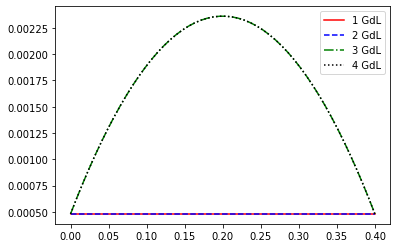

In [12]:
xPlot=np.linspace(0,L,50)

yPlotc1=yApprox0(xPlot,c1)[0]
yPlotc2=yApprox1(xPlot,c2)
yPlotc3=yApprox2(xPlot,c3)
yPlotc4=yApprox3(xPlot,c4)

#print(yPlot)
plt.plot(xPlot,yPlotc1, linewidth=1.5,linestyle="solid",color="red")
plt.plot(xPlot,yPlotc2, linewidth=1.5,linestyle="dashed",color="blue")
plt.plot(xPlot,yPlotc3, linewidth=1.5,linestyle="dashdot",color="green")
plt.plot(xPlot,yPlotc4, linewidth=1.5,linestyle="dotted",color="black")
plt.legend(["1 GdL","2 GdL","3 GdL","4 GdL"])
plt.show